# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

<span style="color:red">Q1: 64, Q2: 3, total: 67

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [3]:
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from numpy import unravel_index
from matplotlib.colors import ListedColormap
from numpy import linspace
%matplotlib inline

## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [83]:
# Load the dataset 
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')
print("Number of datapoints train_A: {}".format(train_A.shape[0]))

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path, delimiter = ',')
print("Number of datapoints in valid_A: {}".format(valid_A.shape[0]))

Number of datapoints train_A: 2093
Number of datapoints in valid_A: 1113


<span style="color:red">OK

### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [84]:
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


<span style="color:red">OK

### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [85]:
attributes_of_interest = train_A.columns[1:501].tolist()
print("Attributes of Interest \(as list\): \n{}".format(attributes_of_interest))

Attributes of Interest \(as list\): 
['dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16', 'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24', 'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32', 'dim33', 'dim34', 'dim35', 'dim36', 'dim37', 'dim38', 'dim39', 'dim40', 'dim41', 'dim42', 'dim43', 'dim44', 'dim45', 'dim46', 'dim47', 'dim48', 'dim49', 'dim50', 'dim51', 'dim52', 'dim53', 'dim54', 'dim55', 'dim56', 'dim57', 'dim58', 'dim59', 'dim60', 'dim61', 'dim62', 'dim63', 'dim64', 'dim65', 'dim66', 'dim67', 'dim68', 'dim69', 'dim70', 'dim71', 'dim72', 'dim73', 'dim74', 'dim75', 'dim76', 'dim77', 'dim78', 'dim79', 'dim80', 'dim81', 'dim82', 'dim83', 'dim84', 'dim85', 'dim86', 'dim87', 'dim88', 'dim89', 'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97', 'dim98', 'dim99', 'dim100', 'dim101', 'dim102', 'dim103', 'dim104', 'dim105', 'dim106', 'dim107', 

<span style="color:red">OK

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [86]:
# split dataset
X_tr = train_A[attributes_of_interest]
y_tr = train_A['is_person']
X_val = valid_A[attributes_of_interest]
y_val = valid_A['is_person']

print("X_tr shape: {}".format(X_tr.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_tr shape: {}".format(y_tr.shape))
print("y_val shape: {}".format(y_val.shape))

X_tr shape: (2093, 500)
X_val shape: (1113, 500)
y_tr shape: (2093,)
y_val shape: (1113,)


<span style="color:red">OK

### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

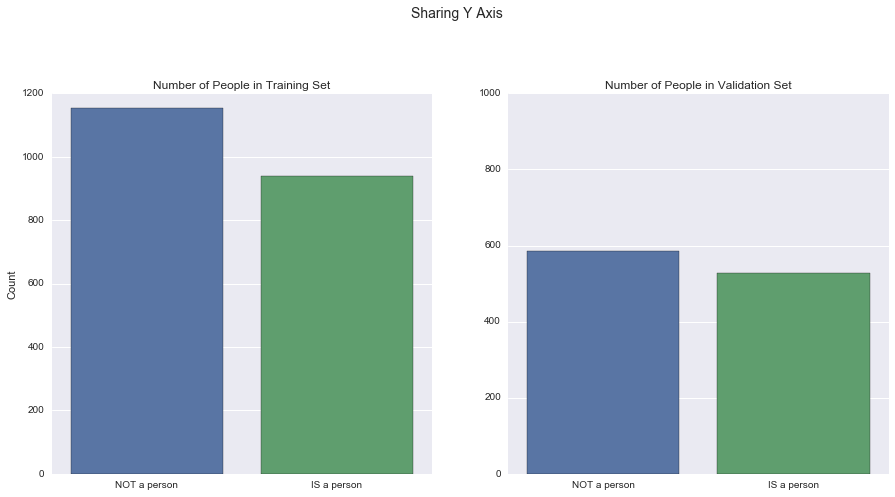

In [87]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1 = sns.countplot(x=y_tr)
ax1.set_title('Number of People in Training Set')
ax1.set_ylabel('Count')
ax1.set_xlabel('')
ax1.set_xticklabels(['NOT a person', 'IS a person'])

ax2 = fig.add_subplot(222)
ax2 = sns.countplot(x=y_val)
ax2.set_ylim([0, 1000])
ax2.set_title('Number of People in Validation Set')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_xticklabels(['NOT a person', 'IS a person'])


fig.suptitle('Sharing Y Axis', fontsize=14)
fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()


<span style="color:red">OK

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

As the graphs show, it is more likely that the image is not a person. So as a baseline classifier we could simply predict that the image does not contain a person (0) every time.

<span style="color:red">OK

In [88]:
zeros = pd.Series(0, index=np.arange(len(y_val)))
ca = accuracy_score(y_val, zeros)
print("Classification Accuracy Score: {:.6f}".format(ca))

Classification Accuracy Score: 0.526505


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [89]:
# Train a logistic regression classifer
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr)
print('Classification accuracy on training set: {:.6f}'.format(lr.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {:.6f}'.format(lr.score(X_val, y_val)))



Classification accuracy on training set: 0.550884
Classification accuracy on validation set: 0.526505


<span style="color:red">OK

Using the logisitic regression classifier we can see this does a poor job by comparing it to the baseline classifier because the classification accuracy for the baseline classifier is .527, and for the logisitic regression classifier it's .55 for the training set and .527 (same thing!!) for the validation set. This tells us the logistic regression classifier is just as effective at predicting if an image contains a person if the predicited not a person (0) all all images. 

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [90]:
# Your code goes here
np.set_printoptions(precision=3)

print("dim1 \nMean Value: {:.6f}".format(X_tr['dim1'].mean()))
print("Standard Deviation: {:.6f}\n".format(X_tr['dim1'].std()))

print("dim2 \nMean Value: {:.6f}".format(X_tr['dim2'].mean()))
print("Standard Deviation: {:.6f}\n".format(X_tr['dim2'].std()))

print("dim3 \nMean Value: {:.6f}".format(X_tr['dim3'].mean()))
print("Standard Deviation: {:.6f}\n".format(X_tr['dim3'].std()))

print("dim4 \nMean Value: {:.6f}".format(X_tr['dim4'].mean()))
print("Standard Deviation: {:.6f}\n".format(X_tr['dim4'].std()))

print("dim5 \nMean Value: {:.6f}".format(X_tr['dim4'].mean()))
print("Standard Deviation: {:.6f}\n".format(X_tr['dim4'].std()))

dim1 
Mean Value: 0.001751
Standard Deviation: 0.001193

dim2 
Mean Value: 0.000756
Standard Deviation: 0.001406

dim3 
Mean Value: 0.004317
Standard Deviation: 0.003693

dim4 
Mean Value: 0.001853
Standard Deviation: 0.001340

dim5 
Mean Value: 0.001853
Standard Deviation: 0.001340



<span style="color:red">OK

### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [91]:
# Create Standardiser
scaler = preprocessing.StandardScaler().fit(X_tr)

# Transform both input and validation input features
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)

print("Training Set:")
for i in range(0,5):
    print("dim{} \nMean Value: {:.6f}".format(str(i), X_tr[:,i].mean()))
    print("Standard Deviation: {:.6f}\n".format(X_tr[:,i].std()))
    
print("\n\nValidation Set:")
for i in range(0,5):
    print("dim{} \nMean Value: {:.6f}".format(str(i), X_val[:,i].mean()))
    print("Standard Deviation: {:.6f}\n".format(X_val[:,i].std()))
    

Training Set:
dim0 
Mean Value: -0.000000
Standard Deviation: 1.000000

dim1 
Mean Value: -0.000000
Standard Deviation: 1.000000

dim2 
Mean Value: 0.000000
Standard Deviation: 1.000000

dim3 
Mean Value: 0.000000
Standard Deviation: 1.000000

dim4 
Mean Value: -0.000000
Standard Deviation: 1.000000



Validation Set:
dim0 
Mean Value: -0.005506
Standard Deviation: 1.013109

dim1 
Mean Value: -0.038293
Standard Deviation: 0.969819

dim2 
Mean Value: 0.109151
Standard Deviation: 1.049228

dim3 
Mean Value: 0.093693
Standard Deviation: 1.056845

dim4 
Mean Value: 0.030578
Standard Deviation: 0.974713



The Standard Scalar standardizes features by removing the mean and scaling to unit variance. This means that the mean will become 0 and standard deviation (unit variance) will become 1, which is the case with our results above. The mean and standard deviation is different for the validation set because we did not use the StandardScalaer() to fit the validation set, only the training set, so this is as expected.

<span style="color:red">OK

### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [92]:
# Retrain the Logistic Regression Classifier
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr)
print('Classification accuracy on training set: {:.6f}'.format(lr.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {:.6f}'.format(lr.score(X_val, y_val)))


Classification accuracy on training set: 0.810798
Classification accuracy on validation set: 0.643306


With the transformed data, the linear regression classifier performs significantly better than the baseline classifier. It is also important to note that the model performs better on the training set than validation set. This is as expected, because it would be suspicious if a model performed better on the validation set than the training set.

<span style="color:red">OK

### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [93]:
# Create a 3-fold cross-validation object
n = X_tr.shape[0]
kf = KFold(n, n_folds=3, shuffle=True, random_state=0)

j = 1
for train_index, test_index in kf:
    X_train, X_test = X_tr[train_index, :], X_tr[test_index, :]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    print("\nKFold #{}".format(j))
    print("Number of training instances: {} \nNumber of testing instances: {}".format(X_train.shape[0], X_test.shape[0]))
    j+=1


KFold #1
Number of training instances: 1395 
Number of testing instances: 698

KFold #2
Number of training instances: 1395 
Number of testing instances: 698

KFold #3
Number of training instances: 1396 
Number of testing instances: 697


<span style="color:red">OK

### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [94]:
# Create 20 evenly spaced values using logspace
num_c_values = 20
c_values = np.logspace(-5, 5, num_c_values)

# Create a 2D array for each cross-validation fold and parameter setting pair
score_array = np.zeros([3,20])

cv_fold = 0
c_index = 0

for train_index, test_index in kf:
    X_train, X_test = X_tr[train_index, :], X_tr[test_index, :]
    y_train, y_test = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    for c in c_values:
        lr_loop = LogisticRegression(solver='lbfgs', C=c)
        lr_loop.fit(X_train, y_train)
        score_array[cv_fold, c_index] = lr_loop.score(X_test, y_test)
        print("KFold: {}, C: {}".format(cv_fold+1, c))
        print('\tClassifcation accuracy for Training Set:   {:.6f}'.format(lr_loop.score(X_train, y_train)))
        print('\tClassifcation accuracy for Validation Set: {:.6f}'.format(lr_loop.score(X_test, y_test)))
        c_index+=1
    print("\n")
    c_index=0
    cv_fold+=1
    

KFold: 1, C: 1e-05
	Classifcation accuracy for Training Set:   0.559140
	Classifcation accuracy for Validation Set: 0.573066
KFold: 1, C: 3.35981828628e-05
	Classifcation accuracy for Training Set:   0.658781
	Classifcation accuracy for Validation Set: 0.628940
KFold: 1, C: 0.000112883789168
	Classifcation accuracy for Training Set:   0.688889
	Classifcation accuracy for Validation Set: 0.667622
KFold: 1, C: 0.000379269019073
	Classifcation accuracy for Training Set:   0.708244
	Classifcation accuracy for Validation Set: 0.671920
KFold: 1, C: 0.0012742749857
	Classifcation accuracy for Training Set:   0.750538
	Classifcation accuracy for Validation Set: 0.687679
KFold: 1, C: 0.00428133239872
	Classifcation accuracy for Training Set:   0.788530
	Classifcation accuracy for Validation Set: 0.696275
KFold: 1, C: 0.0143844988829
	Classifcation accuracy for Training Set:   0.827957
	Classifcation accuracy for Validation Set: 0.674785
KFold: 1, C: 0.0483293023857
	Classifcation accuracy for T

<span style="color:red">OK

### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

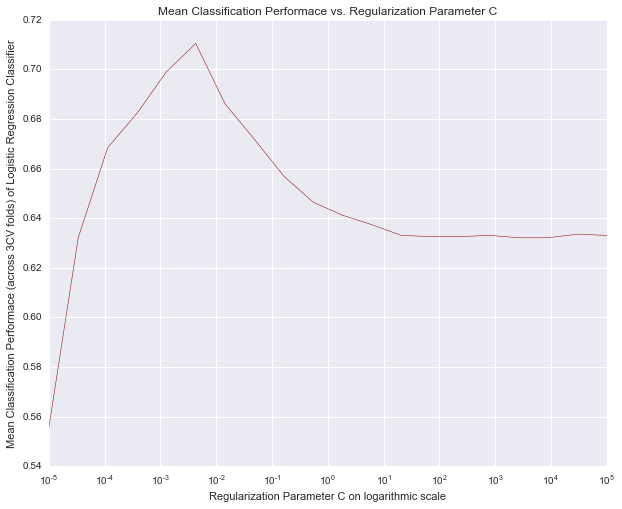

In [95]:
means = np.empty([20,1])
for i in range(num_c_values):
    means[i] = np.mean(score_array[:,i])

plt.figure(figsize=(10, 8))
plt.semilogx(c_values, means, basex=10, color='darkred', linewidth = 0.5)
plt.title('Mean Classification Performace vs. Regularization Parameter C')
plt.xlabel('Regularization Parameter C on logarithmic scale')
plt.ylabel('Mean Classification Performace (across 3CV folds) of Logistic Regression Classifier')
plt.grid(True)


<span style="color:red">OK

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [96]:
optimum = c_values[np.argmax(means)]
print("Optimal C value: {}".format(optimum))
print("Classification Accuracy at this C value: {}".format(np.max(means)))

Optimal C value: 0.00428133239872
Classification Accuracy at this C value: 0.710458521238


<span style="color:red">OK

### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [97]:
lrcv = LogisticRegressionCV(Cs=c_values, cv=kf, solver='lbfgs')
lrcv.fit(X_tr, y_tr)

optimum_lrcv = lrcv.C_

print("Optimal C value: {}".format(optimum_lrcv))
print('Classification accuracy on validation set: {:.6f}'.format(lrcv.score(X_val, y_val)))

#print(lrcv.scores_[1].max())


Optimal C value: [ 0.004]
Classification accuracy on validation set: 0.696316


<span style="color:red">OK

### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [98]:
# Initialise a random forest classifier and fit the model
rf = RandomForestClassifier(n_estimators=500, random_state=31)
rf.fit(X_tr, y_tr)

# Get predictions for training set and validation set
y_predict_tr = rf.predict(X=X_tr)
y_predict_val = rf.predict(X=X_val)

# Get accuracy score for training set and validation set
print("Accuracy Score for Training Set: {}".format(accuracy_score(y_tr, y_predict_tr)))
print("Accuracy Score for Validation Set: {}".format(accuracy_score(y_val, y_predict_val)))

Accuracy Score for Training Set: 1.0
Accuracy Score for Validation Set: 0.700808625337


<span style="color:red">OK

### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

Yes, I find this very surprising. I have never seen an accuracy score of 100% before; this seems way too high. The model performed significantly worse on the validation set. Normally it is expected that the model will perform worse on the validation set than on the training set, but not by more than 30%.

<span style="color:red">normal for unbounded depth RF, you were supposed to use your knowledge of RF to explain that

### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [99]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(50):
    print("%d. %s (%f)" % (f + 1, attributes_of_interest[indices[f]], importances[indices[f]]))


Feature ranking:
1. dim21 (0.008335)
2. dim479 (0.006743)
3. dim360 (0.006573)
4. dim283 (0.006489)
5. dim51 (0.006333)
6. dim76 (0.006276)
7. dim4 (0.005398)
8. dim461 (0.005099)
9. dim330 (0.005098)
10. dim398 (0.005033)
11. dim343 (0.004953)
12. dim222 (0.004787)
13. dim274 (0.004644)
14. dim217 (0.004518)
15. dim485 (0.004488)
16. dim423 (0.004456)
17. dim263 (0.004446)
18. dim356 (0.004366)
19. dim347 (0.004307)
20. dim74 (0.004264)
21. dim214 (0.004226)
22. dim500 (0.004102)
23. dim329 (0.004051)
24. dim92 (0.004048)
25. dim54 (0.004025)
26. dim326 (0.004004)
27. dim90 (0.003917)
28. dim348 (0.003910)
29. dim312 (0.003849)
30. dim154 (0.003785)
31. dim483 (0.003772)
32. dim25 (0.003753)
33. dim289 (0.003738)
34. dim77 (0.003680)
35. dim134 (0.003672)
36. dim254 (0.003636)
37. dim427 (0.003617)
38. dim288 (0.003596)
39. dim73 (0.003556)
40. dim322 (0.003532)
41. dim440 (0.003501)
42. dim17 (0.003470)
43. dim353 (0.003468)
44. dim206 (0.003337)
45. dim171 (0.003235)
46. dim442 (0.0

<span style="color:red">OK

### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [100]:
# Train 3 SVC models with different kernels
svc_linear = SVC(kernel='linear')
svc_rbf = SVC(kernel='rbf')
svc_poly = SVC(kernel='poly')

# fit the 3 SVC models
svc_linear.fit(X_tr, y_tr)
svc_rbf.fit(X_tr, y_tr)
svc_poly.fit(X_tr, y_tr)

# Report classification accuracy of the training and validation sets
print('Linear SVC classification accuracy on training set: {:.3f}'.format(svc_linear.score(X_tr, y_tr)))
print('Linear SVC classification accuracy on test set: {:.3f}'.format(svc_linear.score(X_val, y_val)))
print('\nRBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_tr, y_tr)))
print('RBF SVC classification accuracy on test set: {:.3f}'.format(svc_rbf.score(X_val, y_val)))
print('\nPoly SVC classification accuracy on training set: {:.3f}'.format(svc_poly.score(X_tr, y_tr)))
print('Poly SVC classification accuracy on test set: {:.3f}'.format(svc_poly.score(X_val, y_val)))

Linear SVC classification accuracy on training set: 0.842
Linear SVC classification accuracy on test set: 0.639

RBF SVC classification accuracy on training set: 0.911
RBF SVC classification accuracy on test set: 0.730

Poly SVC classification accuracy on training set: 0.991
Poly SVC classification accuracy on test set: 0.702


<span style="color:red">OK

### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [101]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

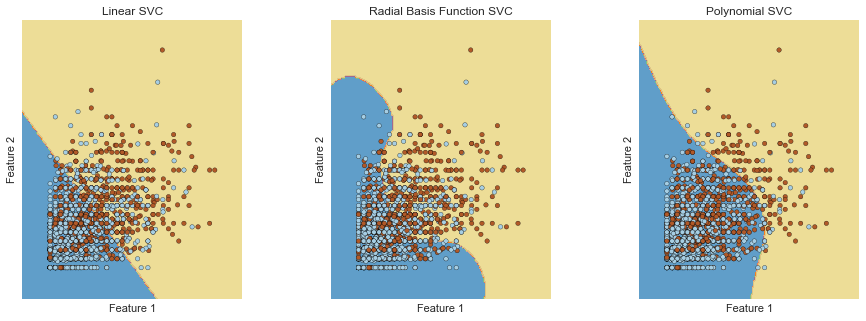

In [102]:
# get 2D input data
X_2d = X_tr[:, [20,75]]

# Train 3 SVC models with different kernels
svc_linear2 = SVC(kernel='linear')
svc_rbf2 = SVC(kernel='rbf')
svc_poly2 = SVC(kernel='poly')

# fit the 3 SVC models
svc_linear2.fit(X_2d, y_tr)
svc_rbf2.fit(X_2d, y_tr)
svc_poly2.fit(X_2d, y_tr)

# create classifier list
class_list = []
class_list.append(svc_linear2)
class_list.append(svc_rbf2)
class_list.append(svc_poly2)

# Plot results
show_svc_decision_boundaries(class_list, X_2d, ['Linear SVC','Radial Basis Function SVC', 'Polynomial SVC'])

I find these results very surprising. It seems like the Radial Basis Function SVC performs the best at separating the data, bit it still looks like there is a lot of missclassification. This explains the relative low classifcation accuracy scores I've been getting above (hovering around .6).

<span style="color:red">fine, any difference between poly and rbf?

### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

Optimal C value: 1.6681005372
Classification Accuracy at this C value: 0.715230644637

Classification Accuracy of Training Set with Optimal Classifier: 0.974677496417
Classification Accuracy of Validation Set with Optimal Classifier: 0.727762803235


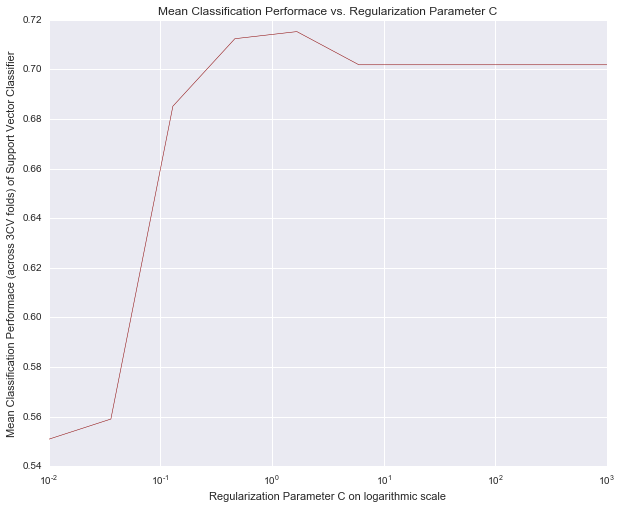

In [103]:
# penalty parameter C in a logarithmic range
num_penalties = 10
penalties = np.logspace(-2, 3, num_penalties)

# Create a 2D array for each cross-validation fold and parameter setting pair
svc_score_array = np.zeros([3,num_penalties])

cv_fold = 0
c_index = 0

for train_index, test_index in kf:
    X_train, X_test = X_tr[train_index, :], X_tr[test_index, :]
    y_train, y_test = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    for c in penalties:
        svc = SVC(kernel='rbf', C=c, gamma='auto')
        svc.fit(X_train, y_train)
        svc_score_array[cv_fold, c_index] = svc.score(X_test, y_test)
        c_index+=1
        
    c_index=0
    cv_fold+=1
    
# get mean cross validation score for each kfold
means2 = np.empty([num_penalties,1])
for i in range(num_penalties):
    means2[i] = np.mean(svc_score_array[:,i])
    
# Plot Results
plt.figure(figsize=(10, 8))
plt.semilogx(penalties, means2, basex=10, color='darkred', linewidth = 0.5)
plt.title('Mean Classification Performace vs. Regularization Parameter C')
plt.xlabel('Regularization Parameter C on logarithmic scale')
plt.ylabel('Mean Classification Performace (across 3CV folds) of Support Vector Classifier')
plt.grid(True)

# get Optimum
optimum = penalties[np.argmax(means2)]
print("Optimal C value: {}".format(optimum))
print("Classification Accuracy at this C value: {}".format(np.max(means2)))

# train classifier with this optimum
svc_optimal = SVC(C=optimum)
svc_optimal.fit(X_tr, y_tr)
print("\nClassification Accuracy of Training Set with Optimal Classifier: {}".format(svc_optimal.score(X_tr, y_tr)))
print("Classification Accuracy of Validation Set with Optimal Classifier: {}".format(svc_optimal.score(X_val, y_val)))


<span style="color:red">OK

### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

Optimal Gamma value: 0.0016681005372
Classification Accuracy at this Gamma value: 0.716185754475

Classification Accuracy of Training Set with Optimal Classifier: 0.891065456283
Classification Accuracy of Validation Set with Optimal Classifier: 0.726864330638


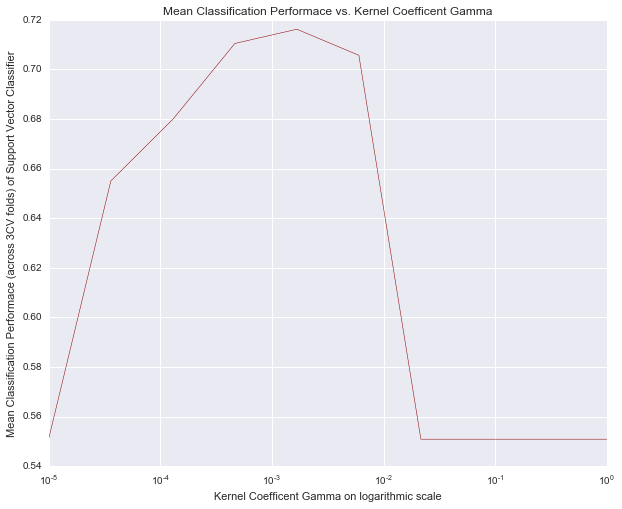

In [104]:
# kernel coefficient parameter gamma in a logarithmic range
num_gammas = 10
gammas = np.logspace(-5, 0, num_gammas)

# Create a 2D array for each cross-validation fold and parameter setting pair
gamma_score_array = np.zeros([3,num_gammas])

cv_fold = 0
c_index = 0

for train_index, test_index in kf:
    X_train, X_test = X_tr[train_index, :], X_tr[test_index, :]
    y_train, y_test = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    for g in gammas:
        svc_gamma = SVC(kernel='rbf', C=1.0, gamma=g)
        svc_gamma.fit(X_train, y_train)
        gamma_score_array[cv_fold, c_index] = svc_gamma.score(X_test, y_test)
        c_index+=1
        
    c_index=0
    cv_fold+=1
    
# get mean cross validation score for each kfold
means_gamma = np.empty([num_gammas,1])
for i in range(num_gammas):
    means_gamma[i] = np.mean(gamma_score_array[:,i])
    
# Plot Results
plt.figure(figsize=(10, 8))
plt.semilogx(gammas, means_gamma, basex=10, color='darkred', linewidth = 0.5)
plt.title('Mean Classification Performace vs. Kernel Coefficent Gamma')
plt.xlabel('Kernel Coefficent Gamma on logarithmic scale')
plt.ylabel('Mean Classification Performace (across 3CV folds) of Support Vector Classifier')
plt.grid(True)

# get Optimum
optimum_gamma = gammas[np.argmax(means_gamma)]
print("Optimal Gamma value: {}".format(optimum_gamma))
print("Classification Accuracy at this Gamma value: {}".format(np.max(means_gamma)))

# train classifier with this optimum
svc_optimal_gamma = SVC(C=1.0, gamma=optimum_gamma)
svc_optimal_gamma.fit(X_tr, y_tr)
print("\nClassification Accuracy of Training Set with Optimal Classifier: {}".format(svc_optimal_gamma.score(X_tr, y_tr)))
print("Classification Accuracy of Validation Set with Optimal Classifier: {}".format(svc_optimal_gamma.score(X_val, y_val)))


<span style="color:red">OK

### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [105]:
C = np.logspace(-2, 1, 4)
gamma = np.logspace(-4, -1, 4)

cg_score_array = np.zeros([3,4,4])

cv_fold=0; c_index=0; gamma_index=0

for train_index, test_index in kf:
    X_train, X_test = X_tr[train_index, :], X_tr[test_index, :]
    y_train, y_test = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    for g in gamma:
        for c in C:
            svc_cg = SVC(kernel='rbf', C=c, gamma=g)
            svc_cg.fit(X_train, y_train)
            cg_score_array[cv_fold, c_index, gamma_index] = svc_cg.score(X_test, y_test)
            c_index+=1
        gamma_index+=1
        c_index=0
        
    c_index=0
    gamma_index=0
    cv_fold+=1

print(cg_score_array)

[[[ 0.56   0.56   0.56   0.56 ]
  [ 0.56   0.676  0.56   0.56 ]
  [ 0.673  0.708  0.658  0.56 ]
  [ 0.699  0.692  0.67   0.56 ]]

 [[ 0.546  0.546  0.546  0.546]
  [ 0.546  0.696  0.546  0.546]
  [ 0.708  0.742  0.649  0.546]
  [ 0.738  0.699  0.679  0.546]]

 [[ 0.547  0.547  0.547  0.547]
  [ 0.547  0.677  0.547  0.547]
  [ 0.663  0.687  0.631  0.547]
  [ 0.693  0.681  0.641  0.547]]]


<span style="color:red">OK

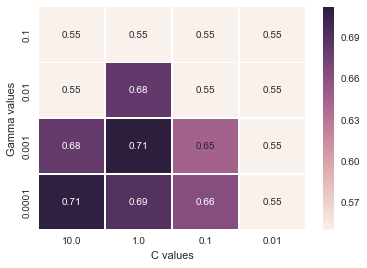

In [106]:
# create 2D array for means
cg_means = np.zeros([4,4])
for i in range(4):
    for j in range(4):
        cg_means[i,j] = np.mean(cg_score_array[:,i,j])

ax = sns.heatmap(cg_means, xticklabels=C[::-1], yticklabels=gamma[::-1], annot=True, linewidths=.5)
ax.set_xlabel('C values')
ax.set_ylabel('Gamma values')

<span style="color:red">OK

In [107]:
# Get Optimal C and gamma values
cg_optimum = unravel_index(cg_means.argmax(), cg_means.shape)
g_optimum = gamma[cg_optimum[1]]
c_optimum = C[cg_optimum[0]]

print("optimal gamma: {}".format(g_optimum))
print("optimal c: {}".format(c_optimum))

# using the optimal configuration, train a classifier
opt_svc = SVC(C=c_optimum, gamma=g_optimum)
opt_svc.fit(X=X_tr, y=y_tr)

print("\nClassification Accuracy of Training Set with Optimal Classifier: {}".format(opt_svc.score(X_tr, y_tr)))
print("Classification Accuracy of Validation Set with Optimal Classifier: {}".format(opt_svc.score(X_val, y_val)))

optimal gamma: 0.001
optimal c: 1.0

Classification Accuracy of Training Set with Optimal Classifier: 0.834687052078
Classification Accuracy of Validation Set with Optimal Classifier: 0.721473495058


### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

The classifcation accuracy score is roughly the same as in previous questions (1.22-1.23). I think this is because we already found where the optimal gamma and c values lie in those questions. In order to more accuretly fine tune we would need to generate values that hover around the numbers we already found (ie, C=.4 and gamma=.001). Perhaps something like:

C = np.logspace(-1, 0, 4) and 
gamma = np.logspace(-3, -2, 4)

<span style="color:red">fine, but what would be the problem with higher resolution of search

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [108]:
degrees = np.arange(1,8)

# Create a 2D array for each cross-validation fold and parameter setting pair
degree_score_array = np.zeros([3,7])

cv_fold = 0
d_index = 0

for train_index, test_index in kf:
    X_train, X_test = X_tr[train_index, :], X_tr[test_index, :]
    y_train, y_test = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    for d in degrees:
        svc_degree = SVC(kernel='poly', degree=d)
        svc_degree.fit(X_train, y_train)
        degree_score_array[cv_fold, d_index] = svc_degree.score(X_test, y_test)
        d_index+=1
        
    d_index=0
    cv_fold+=1

# get mean cross validation score for each kfold
means_degree = np.empty(7)
for i in range(7):
    means_degree[i] = np.mean(degree_score_array[:,i])



<span style="color:red">OK

Optimal Polynomial Degree: 1
Classification Accuracy at this Degree: 0.702810105802

Classification Accuracy of Training Set with Optimal Classifier: 0.783564261825
Classification Accuracy of Validation Set with Optimal Classifier: 0.689128481581


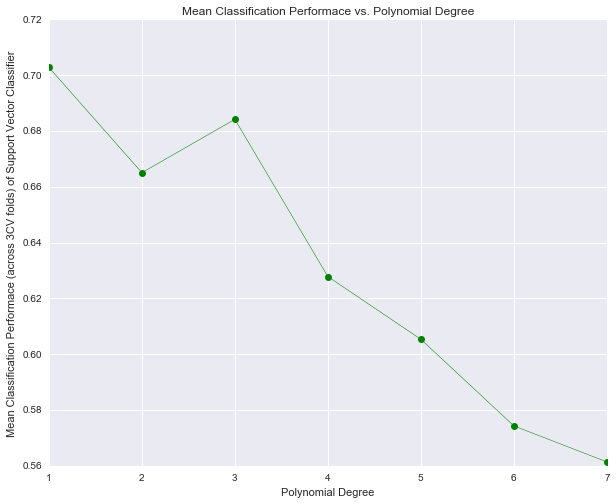

In [109]:
# Plot Results
plt.figure(figsize=(10, 8))
plt.plot(degrees, means_degree, 'go-', linewidth=.5)
plt.title('Mean Classification Performace vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Classification Performace (across 3CV folds) of Support Vector Classifier')
plt.grid(True)

# get Optimum
optimum_degree = degrees[np.argmax(means_degree)]
print("Optimal Polynomial Degree: {}".format(optimum_degree))
print("Classification Accuracy at this Degree: {}".format(np.max(means_degree)))

# train classifier with this optimum
svc_optimal_degree = SVC(kernel='poly', degree=optimum_degree)
svc_optimal_degree.fit(X_tr, y_tr)
print("\nClassification Accuracy of Training Set with Optimal Classifier: {}".format(svc_optimal_degree.score(X_tr, y_tr)))
print("Classification Accuracy of Validation Set with Optimal Classifier: {}".format(svc_optimal_degree.score(X_val, y_val)))


### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

I think it is good to use cross-validation for optimising parameters; however, cross validation didn't make much of a difference when optimizing, it often changed a very small insignificant part of the value were were trying to optimize. I think we would have had better results if we utilized the validation set. As you can see from our results in questions in questions 1.21-1.25, we perform signifantly better on the Training Set than the Validation Set. If we utilized the validation set, we might see better results on the validation set. 

<span style="color:red">incomplete

### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [24]:
# Load the dataset 
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path, delimiter = ',')

# Remove the imgId attribute
train_A = train_A.drop('imgId', axis=1)
valid_A = valid_A.drop('imgId', axis=1)

# Split Dataset
X_tr = train_A.drop('is_person', axis=1)
y_tr = train_A['is_person']
X_val = valid_A.drop('is_person', axis=1)
y_val = valid_A['is_person']

# Create Standardiser
scaler = preprocessing.StandardScaler().fit(X_tr)

# Transform both input and validation input features
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500, random_state=31)
rf.fit(X_tr, y_tr)
print('Classification accuracy on training set: {:.6f}'.format(rf.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {:.6f}'.format(rf.score(X_val, y_val)))

# Get most important features
headers = list(train_A.drop('is_person', axis=1).columns.values)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(50):
    print("%d. %s (%f)" % (f + 1, headers[indices[f]], importances[indices[f]]))

Classification accuracy on training set: 1.000000
Classification accuracy on validation set: 0.719677
Feature ranking:
1. is_cat (0.008605)
2. is_bird (0.008318)
3. dim21 (0.007989)
4. dim51 (0.007203)
5. dim360 (0.006534)
6. dim76 (0.006491)
7. dim479 (0.005844)
8. dim4 (0.005513)
9. dim398 (0.005442)
10. dim461 (0.005089)
11. dim283 (0.004917)
12. dim330 (0.004818)
13. dim485 (0.004817)
14. dim423 (0.004735)
15. dim343 (0.004729)
16. dim348 (0.004682)
17. dim217 (0.004490)
18. dim222 (0.004384)
19. dim74 (0.004349)
20. dim274 (0.004332)
21. dim90 (0.004315)
22. dim288 (0.004271)
23. dim214 (0.004245)
24. dim356 (0.004061)
25. dim263 (0.004058)
26. dim254 (0.003957)
27. dim500 (0.003826)
28. dim483 (0.003770)
29. dim347 (0.003701)
30. dim134 (0.003592)
31. dim326 (0.003534)
32. dim154 (0.003496)
33. dim35 (0.003453)
34. dim322 (0.003439)
35. dim289 (0.003439)
36. dim329 (0.003417)
37. dim73 (0.003400)
38. dim92 (0.003330)
39. dim17 (0.003295)
40. dim427 (0.003216)
41. dim430 (0.003192

What do you notice by looking at the list of the best 50 features?
Attributes is_cat and is_bird were the two most important features. This makes sense because if you're trying to predict whether the image contains a person, the predictor could confuse a person with other creatures like a car or a bird. But with that logic, then the rest of the class indicator variables should also be in the important features list.

How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
Without the additional class indicator variables, the validation set had a classification accuracy of 0.7008
With the additional class indicator variables, the validation set had a classifcation accuracy of 0.7196
So we only saw a 1% improvement in classification accuracy and it seems like the additional class indicator variables didn't make much of a difference. They also have pretty similar feature imporancy lists, with dim21 and dim479 being close to the top.

Would it be easy to make use of the results in practice? Briefly explain your reasoning.
Not really, I think this data basically told us that additional class indicator variables are pointless and aren't going to really help your predictor. So I guess it helps in that you don't have to do a much of extra work getting additional class indicator variables to put in your dataset.

<span style="color:red">you're on the right track but didn't quite get why is_cat and is_bird are so good - it's not because they're easy to confuse with a person but it's because pics with cats or birds rarely contain a person in them too

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

*Your answer goes here (max. 600 words)*



<span style="color:red"> no answer and poor perfomance of your classifier, 2/10

In [22]:
# Load the dataset 
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(data_path, delimiter = ',')

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(data_path, delimiter = ',')

data_path = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(data_path, delimiter = ',')

# Get attributes
attributes_of_interest = train_B.columns[1:501].tolist()

# Split Dataset
X_tr = train_B[attributes_of_interest]
y_tr = train_B['is_person']
X_val = valid_B[attributes_of_interest]
y_val = valid_B['is_person']
X_test = test_B[attributes_of_interest]


In [26]:
# Classifiers to Test
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Polynomial SVM",
         "Decision Tree", "Random Forest", "Naive Bayes"]
classifiers = [
    KNeighborsClassifier(3), 
    SVC(kernel="linear", probability=True), SVC(probability=True), SVC(kernel="poly", degree=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GaussianNB()]

# Preprocess Dataset
X_tr = preprocessing.RobustScaler().fit_transform(X_tr)
X_val = preprocessing.RobustScaler().fit_transform(X_val)

# iterate over classifiers
train_scores = np.empty(len(classifiers))
val_scores = np.empty(len(classifiers))
index = 0

for name, clf in zip(names, classifiers):
    clf.fit(X_tr, y_tr)
    train_scores[index] = clf.score(X_tr, y_tr)
    val_scores[index] = clf.score(X_val, y_val)
    index += 1
